# Topic: US Income Tax Audit Algorithms
Team members: Shuyi Zhu, Scott McCoy, Agnes(Tzuhua) Huang, Roozbeh Jafari



In [ ]:
import pandas as pd
import random
import numpy as np

from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns

random.seed(10)

# Data Setup

Datasets:
* Audit Rates by County from ProPublica 
* Tax Return Data by County from IRS 
* Demographic Data by County from Kaggle


## Audit Rates

* Audit rates (per 1000 returns) gathered by ProPublica
* https://github.com/propublica/auditData

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/propublica/auditData/master/data/cleaned/auditsData_2019.04.03.csv')

In [ ]:
df

,fips,name,state,Number_of_returns,estimated_exams,audit_rate,audit_rate_trunk
0,1001,"Autauga County, Alabama",Alabama,95170.0,721.0,7.575917,7.575917
1,1003,"Baldwin County, Alabama",Alabama,362490.0,2833.0,7.815388,7.815388
2,1005,"Barbour County, Alabama",Alabama,39440.0,360.0,9.127789,9.127789
3,1007,"Bibb County, Alabama",Alabama,31840.0,260.0,8.165829,8.165829
4,1009,"Blount County, Alabama",Alabama,87970.0,673.0,7.650335,7.650335
...,...,...,...,...,...,...,...
3136,56037,"Sweetwater County, Wyoming",Wyoming,84960.0,578.0,6.803202,6.803202
3137,56039,"Teton County, Wyoming",Wyoming,57890.0,447.0,7.721541,7.721541
3138,56041,"Uinta County, Wyoming",Wyoming,37540.0,266.0,7.085775,7.085775
3139,56043,"Washakie County, Wyoming",Wyoming,15830.0,110.0,6.948831,6.948831


In [ ]:
df[df['audit_rate'] != df['audit_rate_trunk']]
# audit rate trunk - floor of 6 for visualization purposes
# only 63 counties - outliers

,fips,name,state,Number_of_returns,estimated_exams,audit_rate,audit_rate_trunk
67,2013,"Aleutians East Borough, Alaska",Alaska,3960.0,23.0,5.808081,6.0
71,2060,"Bristol Bay Borough, Alaska",Alaska,2140.0,7.0,3.271028,6.0
72,2068,"Denali Borough, Alaska",Alaska,4620.0,26.0,5.627706,6.0
89,2230,"Skagway Municipality, Alaska",Alaska,3050.0,18.0,5.901639,6.0
94,2282,"Yakutat City and Borough, Alaska",Alaska,1160.0,3.0,2.586207,6.0
...,...,...,...,...,...,...,...
2718,48393,"Roberts County, Texas",Texas,1600.0,6.0,3.750000,6.0
2737,48431,"Sterling County, Texas",Texas,2360.0,10.0,4.237288,6.0
2743,48443,"Terrell County, Texas",Texas,1550.0,6.0,3.870968,6.0
2780,49009,"Daggett County, Utah",Utah,1710.0,4.0,2.339181,6.0


In [ ]:
# splitting 'fips' code into state and county columns for matching purposes
df['st_code'] = df['fips'].astype('str').str[:-3].astype('int')
df['cty_code'] = df['fips'].astype('str').str[-3:].astype('int')

## Income

Demographic Data by County from Kaggle:

https://www.kaggle.com/muonneutrino/us-census-demographic-data

In [ ]:
dfi = pd.read_csv('https://raw.githubusercontent.com/Roozbeh-jafari/840.Data-Ethics-US-Taxpayers-Algorithms/main/DataSets/acs2015_county_data.csv?token=ARFHYYA2GCAOYQ6SAD3UFY3AWACHA')
# dfi = pd.read_csv('acs2015_county_data.csv')
# dfi = pd.read_csv('/content/acs2015_county_data.csv')
# dfi = pd.read_csv('../Datasets/acs2015_county_data.csv')

In [ ]:
dfi

,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,Alabama,Autauga,55221,26745,28476,2.6,75.8,18.5,0.4,1.0,0.0,40725,51281.0,2391.0,24974,1080,12.9,18.6,33.2,17.0,24.2,8.6,17.1,87.5,8.8,0.1,0.5,1.3,1.8,26.5,23986,73.6,20.9,5.5,0.0,7.6
1,1003,Alabama,Baldwin,195121,95314,99807,4.5,83.1,9.5,0.6,0.7,0.0,147695,50254.0,1263.0,27317,711,13.4,19.2,33.1,17.7,27.1,10.8,11.2,84.7,8.8,0.1,1.0,1.4,3.9,26.4,85953,81.5,12.3,5.8,0.4,7.5
2,1005,Alabama,Barbour,26932,14497,12435,4.6,46.2,46.7,0.2,0.4,0.0,20714,32964.0,2973.0,16824,798,26.7,45.3,26.8,16.1,23.1,10.8,23.1,83.8,10.9,0.4,1.8,1.5,1.6,24.1,8597,71.8,20.8,7.3,0.1,17.6
3,1007,Alabama,Bibb,22604,12073,10531,2.2,74.5,21.4,0.4,0.1,0.0,17495,38678.0,3995.0,18431,1618,16.8,27.9,21.5,17.9,17.8,19.0,23.7,83.2,13.5,0.5,0.6,1.5,0.7,28.8,8294,76.8,16.1,6.7,0.4,8.3
4,1009,Alabama,Blount,57710,28512,29198,8.6,87.9,1.5,0.3,0.1,0.0,42345,45813.0,3141.0,20532,708,16.7,27.2,28.5,14.1,23.9,13.5,19.9,84.9,11.2,0.4,0.9,0.4,2.3,34.9,22189,82.0,13.5,4.2,0.4,7.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3215,72145,Puerto Rico,Vega Baja,56858,27379,29479,96.4,3.4,0.1,0.0,0.0,0.0,43656,16948.0,1234.0,9102,538,48.5,56.1,30.1,21.6,24.7,9.2,14.3,89.1,7.1,0.9,1.2,1.3,0.3,32.0,13660,78.3,17.6,4.1,0.0,15.2
3216,72147,Puerto Rico,Vieques,9130,4585,4545,96.7,2.9,0.0,0.0,0.0,0.0,7085,18104.0,3771.0,8821,939,39.1,58.1,18.4,38.2,18.5,15.7,9.1,69.1,17.8,1.0,10.8,0.0,1.4,14.0,2860,44.5,41.6,13.6,0.3,12.2
3217,72149,Puerto Rico,Villalba,24685,12086,12599,99.7,0.0,0.0,0.0,0.0,0.0,18458,17818.0,1255.0,8420,486,54.0,68.3,23.6,21.0,21.8,13.9,19.7,82.0,11.4,0.1,3.2,0.0,3.3,26.9,6795,59.2,27.5,13.1,0.2,25.9
3218,72151,Puerto Rico,Yabucoa,36279,17648,18631,99.8,0.2,0.0,0.0,0.1,0.0,27924,15627.0,1836.0,7960,512,52.3,62.1,25.9,25.9,20.7,12.8,14.7,86.0,7.9,0.0,2.3,2.3,1.5,29.5,8083,65.1,27.6,7.3,0.0,24.3


## Tax Return

Tax return data by US county

https://www.irs.gov/statistics/compliance-presence

In [ ]:
dft = pd.read_csv('https://raw.githubusercontent.com/Roozbeh-jafari/840.Data-Ethics-US-Taxpayers-Algorithms/main/DataSets/tax-return-2015.csv?token=ARFHYYG36GHMQAHWGRLTBI3AWACJY')
# dft = pd.read_csv('tax-return-2015.csv')
# dft = pd.read_csv('/content/tax-return-2015.csv')
# dft = pd.read_csv('../Datasets/tax-return-2015.csv')
dft

,State FIPS code [1],State,County FIPS code [1],County name,Number of returns,Number of single returns,Number of joint returns,Number of head of household returns,Number with paid preparer's signature,Number of exemptions,Number of dependents,Number of volunteer prepared returns [2],Number of volunteer income tax assistance (VITA) prepared returns,Number of tax counseling for the elderly (TCE) prepared returns,Number of volunteer prepared \nreturns with\nEarned Income Credit,Number of refund anticipation loan returns,Number of refund anticipation check returns,Number of elderly returns [3],Adjusted gross income (AGI) [4],Total income num,Total income amt,Salaries and wages in AGI num,Salaries and wages in AGI amt,Taxable interest num,Taxable interest amt,Ordinary dividends num,Ordinary dividends amt,Qualified dividends [5] num,Qualified dividends [5] amt,State and local income tax refunds\n num,State and local income tax refunds\n amt,Business or profession\nnet income (less loss) num,Business or profession\nnet income (less loss) amt,Net capital gain (less loss) in AGI num,Net capital gain (less loss) in AGI amt,Taxable individual retirement\narrangement distributions num,Taxable individual retirement\narrangement distributions amt,Pensions and annuities in AGI num,Pensions and annuities in AGI amt,Number of \nfarm returns num,...,Nonrefundable education credit num,Nonrefundable education credit amt,Retirement savings contribution credit num,Retirement savings contribution credit amt,Child tax credit num,Child tax credit amt,Residential energy tax credit num,Residential energy tax credit amt,Self-employment tax num,Self-employment tax amt,Total premium tax credit num,Total premium tax credit amt,Advance premium tax credit num,Advance premium tax credit amt,Health care individual responsibility payment num,Health care individual responsibility payment amt,Total tax payments num,Total tax payments amt,Earned income credit [7] num,Earned income credit [7] amt,Excess earned income credit \n(refundable) [8] num,Excess earned income credit \n(refundable) [8] amt,Additional child tax credit num,Additional child tax credit amt,Refundable education credit num,Refundable education credit amt,Net premium tax credit num,Net premium tax credit amt,Income tax [9] num,Income tax [9] amt,Total tax liability [10] num,Total tax liability [10] amt,Additional Medicare tax num,Additional Medicare tax amt,Net investment income tax num,Net investment income tax amt,Tax due at time of filing [11] num,Tax due at time of filing [11] amt,Overpayments refunded [12] num,Overpayments refunded [12] amt
0,0,US,0,Total [13],148965910,70209250,53923170,21890640,80046180,289089330,95564540,3549610,1855800,1693980,526520,457940,21365980,34715360,10074264203,148463360,10223004480,123272570,7008525735,42221420,89362337,27438590,246436572,25603510,191255367,20154420,30623936,24704120,335562990,24187930,667720309,13973180,249199152,27891270,680105287,1853030,...,9671340,10242220,7969270,1395349,22262740,26867439,2594560,2128417,19385880,59225710,5166550,18878404,5836460,20882039,6653270,3064758,140778140,1766105893,27972300,68008777,23959360,58451691,19400100,26045489,9635000,8567079,2403200,1596320,102005440,1432106443,112137600,1522112987,3475390,7607693,3781620,21033338,28883270,159391261,112176640,350257176
1,1,AL,0,Alabama,2053620,834300,763210,415730,1172420,4166050,1467040,45570,28830,16760,7720,15400,457080,477210,111789331,2046690,113236900,1710150,80323944,502130,763242,268410,1724024,246330,1351071,318950,340193,345310,3128573,228700,4203762,171570,2797936,421830,10091228,45200,...,145900,154923,122430,22009,331830,386740,39130,19239,251070,638724,79620,275503,86890,295407,70350,29736,1960840,17604731,521420,1444531,467990,1279982,360840,481943,173090,163859,39440,21778,1303380,13179616,1458720,14075850,24800,43315,30150,111100,361940,1717754,1607070,4845454
2,1,AL,1,Autauga County,23960,9130,10020,4290,10960,50220,17800,510,130,370,0,70,5150,5160,129101

In [ ]:
# adding ratio columns
dft['volunteer_preparer_percentage'] = dft['Number of volunteer prepared returns [2]'] / dft['Number of returns']
dft['paid_preparer_percentage'] = dft['Number with paid preparer\'s signature'] / dft['Number of returns']
dft['wage_income_percentage'] = dft['Salaries and wages in AGI num'] / dft['Number of returns']
dft['dividends_percentage'] = dft['Qualified dividends [5] num'] / dft['Number of returns']
dft['cap_gain_percentage'] =  dft['Net capital gain (less loss) in AGI num'] / dft['Number of returns']
dft['eic_percentage'] =  dft['Earned income credit [7] num'] / dft['Number of returns']

In [ ]:
dft[dft['Number of returns'] > 10000].sort_values('dividends_percentage', ascending = False)

# counties w. > 10,000 returns sorted by percentage of returns with divend income (wealthy populations)

,State FIPS code [1],State,County FIPS code [1],County name,Number of returns,Number of single returns,Number of joint returns,Number of head of household returns,Number with paid preparer's signature,Number of exemptions,Number of dependents,Number of volunteer prepared returns [2],Number of volunteer income tax assistance (VITA) prepared returns,Number of tax counseling for the elderly (TCE) prepared returns,Number of volunteer prepared \nreturns with\nEarned Income Credit,Number of refund anticipation loan returns,Number of refund anticipation check returns,Number of elderly returns [3],Adjusted gross income (AGI) [4],Total income num,Total income amt,Salaries and wages in AGI num,Salaries and wages in AGI amt,Taxable interest num,Taxable interest amt,Ordinary dividends num,Ordinary dividends amt,Qualified dividends [5] num,Qualified dividends [5] amt,State and local income tax refunds\n num,State and local income tax refunds\n amt,Business or profession\nnet income (less loss) num,Business or profession\nnet income (less loss) amt,Net capital gain (less loss) in AGI num,Net capital gain (less loss) in AGI amt,Taxable individual retirement\narrangement distributions num,Taxable individual retirement\narrangement distributions amt,Pensions and annuities in AGI num,Pensions and annuities in AGI amt,Number of \nfarm returns num,...,Residential energy tax credit num,Residential energy tax credit amt,Self-employment tax num,Self-employment tax amt,Total premium tax credit num,Total premium tax credit amt,Advance premium tax credit num,Advance premium tax credit amt,Health care individual responsibility payment num,Health care individual responsibility payment amt,Total tax payments num,Total tax payments amt,Earned income credit [7] num,Earned income credit [7] amt,Excess earned income credit \n(refundable) [8] num,Excess earned income credit \n(refundable) [8] amt,Additional child tax credit num,Additional child tax credit amt,Refundable education credit num,Refundable education credit amt,Net premium tax credit num,Net premium tax credit amt,Income tax [9] num,Income tax [9] amt,Total tax liability [10] num,Total tax liability [10] amt,Additional Medicare tax num,Additional Medicare tax amt,Net investment income tax num,Net investment income tax amt,Tax due at time of filing [11] num,Tax due at time of filing [11] amt,Overpayments refunded [12] num,Overpayments refunded [12] amt,volunteer_preparer_percentage,paid_preparer_percentage,wage_income_percentage,dividends_percentage,cap_gain_percentage,eic_percentage
1813,34,NJ,19,Hunterdon County,64620,29980,29410,4120,39990,122900,35850,1200,1060,130,220,0,3050,18680,7689706,64490,7835302,52340,5435316,29620,50326,26940,210596,25660,162584,17180,34002,11680,305709,22440,439415,9610,217142,14340,411313,1410,...,1830,1454,10060,50492,1580,7605,1840,8551,1620,894,60710,1495165,3440,5491,2510,4287,2010,2475,3310,3265,760,864,51350,1358257,53730,1435113,5920,11773,5370,12796,17050,137075,42330,146439,0.018570,0.618849,0.809966,0.397091,0.347261,0.053234
389,12,FL,119,Sumter County,55010,20100,30600,3460,27050,97130,12340,6720,50,6670,0,30,3960,39270,4047803,54790,4097430,24610,969323,28690,69477,23290,191614,21790,140086,2320,4092,5980,64339,21050,309635,22910,504241,32140,1079604,640,...,1560,678,4510,11235,1960,9065,2240,10206,1310,646,49550,685964,5430,13000,4660,11362,3290,4564,940,813,810,600,40740,581465,42790,601857,350,672,1180,7398,14510,69364,34260,132747,0.122160,0.491729,0.447373,0.396110,0.382658,0.098709
212,6,CA,41,Marin County,132580,67110,51990,11250,85400,245630,69200,2670,760,1920,240,0,5650,45950,22455167,132120,23006100,92480,11778965,63780,273964,55050,1174705,52350,923269,29000,127648,37640,1435995,53720,3891232,21460,626341,25110,864938,370,...,2000,4797,33410,212290,5680,30083,6890,34803,3420,2033,119520,5220628,9000,14985,6010,10473,6620,8423,3920,3160,3010,3142,102240,4651959,111170,5007282,14360,45073,16270,136967,44780,502657,68740,430535,0.020139,0.644139,0

## Merge

In [ ]:
# merging demographic with audit rates
dfmm = df.merge(dfi, how = 'left', left_on='fips', right_on='CensusId').dropna()
dfmm.head()

# dfmm.to_csv('audit-demographics-merged.csv', index = False)
# to save to csv

,fips,name,state,Number_of_returns,estimated_exams,audit_rate,audit_rate_trunk,st_code,cty_code,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001,"Autauga County, Alabama",Alabama,95170.0,721.0,7.575917,7.575917,1,1,1001.0,Alabama,Autauga,55221.0,26745.0,28476.0,2.6,75.8,18.5,0.4,1.0,0.0,40725.0,51281.0,2391.0,24974.0,1080.0,12.9,18.6,33.2,17.0,24.2,8.6,17.1,87.5,8.8,0.1,0.5,1.3,1.8,26.5,23986.0,73.6,20.9,5.5,0.0,7.6
1,1003,"Baldwin County, Alabama",Alabama,362490.0,2833.0,7.815388,7.815388,1,3,1003.0,Alabama,Baldwin,195121.0,95314.0,99807.0,4.5,83.1,9.5,0.6,0.7,0.0,147695.0,50254.0,1263.0,27317.0,711.0,13.4,19.2,33.1,17.7,27.1,10.8,11.2,84.7,8.8,0.1,1.0,1.4,3.9,26.4,85953.0,81.5,12.3,5.8,0.4,7.5
2,1005,"Barbour County, Alabama",Alabama,39440.0,360.0,9.127789,9.127789,1,5,1005.0,Alabama,Barbour,26932.0,14497.0,12435.0,4.6,46.2,46.7,0.2,0.4,0.0,20714.0,32964.0,2973.0,16824.0,798.0,26.7,45.3,26.8,16.1,23.1,10.8,23.1,83.8,10.9,0.4,1.8,1.5,1.6,24.1,8597.0,71.8,20.8,7.3,0.1,17.6
3,1007,"Bibb County, Alabama",Alabama,31840.0,260.0,8.165829,8.165829,1,7,1007.0,Alabama,Bibb,22604.0,12073.0,10531.0,2.2,74.5,21.4,0.4,0.1,0.0,17495.0,38678.0,3995.0,18431.0,1618.0,16.8,27.9,21.5,17.9,17.8,19.0,23.7,83.2,13.5,0.5,0.6,1.5,0.7,28.8,8294.0,76.8,16.1,6.7,0.4,8.3
4,1009,"Blount County, Alabama",Alabama,87970.0,673.0,7.650335,7.650335,1,9,1009.0,Alabama,Blount,57710.0,28512.0,29198.0,8.6,87.9,1.5,0.3,0.1,0.0,42345.0,45813.0,3141.0,20532.0,708.0,16.7,27.2,28.5,14.1,23.9,13.5,19.9,84.9,11.2,0.4,0.9,0.4,2.3,34.9,22189.0,82.0,13.5,4.2,0.4,7.7


In [ ]:
# merging tax return with audit rates
dftm = dft.merge(df, how = 'left',left_on = ['State FIPS code [1]', 'County FIPS code [1]'], right_on= ['st_code', 'cty_code'])
dftm.head()

# dftm.to_csv('tax-return-merged.csv', index= False)   # saving to csv

,State FIPS code [1],State,County FIPS code [1],County name,Number of returns,Number of single returns,Number of joint returns,Number of head of household returns,Number with paid preparer's signature,Number of exemptions,Number of dependents,Number of volunteer prepared returns [2],Number of volunteer income tax assistance (VITA) prepared returns,Number of tax counseling for the elderly (TCE) prepared returns,Number of volunteer prepared \nreturns with\nEarned Income Credit,Number of refund anticipation loan returns,Number of refund anticipation check returns,Number of elderly returns [3],Adjusted gross income (AGI) [4],Total income num,Total income amt,Salaries and wages in AGI num,Salaries and wages in AGI amt,Taxable interest num,Taxable interest amt,Ordinary dividends num,Ordinary dividends amt,Qualified dividends [5] num,Qualified dividends [5] amt,State and local income tax refunds\n num,State and local income tax refunds\n amt,Business or profession\nnet income (less loss) num,Business or profession\nnet income (less loss) amt,Net capital gain (less loss) in AGI num,Net capital gain (less loss) in AGI amt,Taxable individual retirement\narrangement distributions num,Taxable individual retirement\narrangement distributions amt,Pensions and annuities in AGI num,Pensions and annuities in AGI amt,Number of \nfarm returns num,...,Health care individual responsibility payment amt,Total tax payments num,Total tax payments amt,Earned income credit [7] num,Earned income credit [7] amt,Excess earned income credit \n(refundable) [8] num,Excess earned income credit \n(refundable) [8] amt,Additional child tax credit num,Additional child tax credit amt,Refundable education credit num,Refundable education credit amt,Net premium tax credit num,Net premium tax credit amt,Income tax [9] num,Income tax [9] amt,Total tax liability [10] num,Total tax liability [10] amt,Additional Medicare tax num,Additional Medicare tax amt,Net investment income tax num,Net investment income tax amt,Tax due at time of filing [11] num,Tax due at time of filing [11] amt,Overpayments refunded [12] num,Overpayments refunded [12] amt,volunteer_preparer_percentage,paid_preparer_percentage,wage_income_percentage,dividends_percentage,cap_gain_percentage,eic_percentage,fips,name,state,Number_of_returns,estimated_exams,audit_rate,audit_rate_trunk,st_code,cty_code
0,0,US,0,Total [13],148965910,70209250,53923170,21890640,80046180,289089330,95564540,3549610,1855800,1693980,526520,457940,21365980,34715360,10074264203,148463360,10223004480,123272570,7008525735,42221420,89362337,27438590,246436572,25603510,191255367,20154420,30623936,24704120,335562990,24187930,667720309,13973180,249199152,27891270,680105287,1853030,...,3064758,140778140,1766105893,27972300,68008777,23959360,58451691,19400100,26045489,9635000,8567079,2403200,1596320,102005440,1432106443,112137600,1522112987,3475390,7607693,3781620,21033338,28883270,159391261,112176640,350257176,0.023828,0.537346,0.827522,0.171875,0.162372,0.187777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,AL,0,Alabama,2053620,834300,763210,415730,1172420,4166050,1467040,45570,28830,16760,7720,15400,457080,477210,111789331,2046690,113236900,1710150,80323944,502130,763242,268410,1724024,246330,1351071,318950,340193,345310,3128573,228700,4203762,171570,2797936,421830,10091228,45200,...,29736,1960840,17604731,521420,1444531,467990,1279982,360840,481943,173090,163859,39440,21778,1303380,13179616,1458720,14075850,24800,43315,30150,111100,361940,1717754,1607070,4845454,0.022190,0.570904,0.832749,0.119949,0.111364,0.253903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,AL,1,Autauga County,23960,9130,10020,4290,10960,50220,17800,510,130,370,0,70,5150,5160,1291011,23880,1304385,20360,979232,7210,5850,3030,9391,2740,7109,3770,3235,3490,28135,2520,17134,1930,25374,5520,147466,380,...,323,23120,175903,5240,14098,4650,12521,3630,4716,1870,1743,390,195,16400,126990,17800,135207,120,115,170,387,4310,14233,18910,53521,0.021285,0.457429,0.849750,0.114357,0.105175,0.

In [ ]:
# merging demographic, tax return, and audit rates
# dataframe with all variables of interest

dfmt = df.merge(dfi, how = 'left', left_on='fips', right_on='CensusId')
dfma = dfmt.merge(dft, how = 'left', left_on =['st_code', 'cty_code'], right_on = ['State FIPS code [1]', 'County FIPS code [1]'] )
dfma.head()

# dfma.to_csv('../Datasets/merged-all.csv', index=False)

,fips,name,state,Number_of_returns,estimated_exams,audit_rate,audit_rate_trunk,st_code,cty_code,CensusId,State_x,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,...,Residential energy tax credit num,Residential energy tax credit amt,Self-employment tax num,Self-employment tax amt,Total premium tax credit num,Total premium tax credit amt,Advance premium tax credit num,Advance premium tax credit amt,Health care individual responsibility payment num,Health care individual responsibility payment amt,Total tax payments num,Total tax payments amt,Earned income credit [7] num,Earned income credit [7] amt,Excess earned income credit \n(refundable) [8] num,Excess earned income credit \n(refundable) [8] amt,Additional child tax credit num,Additional child tax credit amt,Refundable education credit num,Refundable education credit amt,Net premium tax credit num,Net premium tax credit amt,Income tax [9] num,Income tax [9] amt,Total tax liability [10] num,Total tax liability [10] amt,Additional Medicare tax num,Additional Medicare tax amt,Net investment income tax num,Net investment income tax amt,Tax due at time of filing [11] num,Tax due at time of filing [11] amt,Overpayments refunded [12] num,Overpayments refunded [12] amt,volunteer_preparer_percentage,paid_preparer_percentage,wage_income_percentage,dividends_percentage,cap_gain_percentage,eic_percentage
0,1001,"Autauga County, Alabama",Alabama,95170.0,721.0,7.575917,7.575917,1,1,1001.0,Alabama,Autauga,55221.0,26745.0,28476.0,2.6,75.8,18.5,0.4,1.0,0.0,40725.0,51281.0,2391.0,24974.0,1080.0,12.9,18.6,33.2,17.0,24.2,8.6,17.1,87.5,8.8,0.1,0.5,1.3,1.8,26.5,...,410.0,143.0,2550.0,6138.0,780.0,2376.0,840.0,2604.0,710.0,323.0,23120.0,175903.0,5240.0,14098.0,4650.0,12521.0,3630.0,4716.0,1870.0,1743.0,390.0,195.0,16400.0,126990.0,17800.0,135207.0,120.0,115.0,170.0,387.0,4310.0,14233.0,18910.0,53521.0,0.021285,0.457429,0.849750,0.114357,0.105175,0.218698
1,1003,"Baldwin County, Alabama",Alabama,362490.0,2833.0,7.815388,7.815388,1,3,1003.0,Alabama,Baldwin,195121.0,95314.0,99807.0,4.5,83.1,9.5,0.6,0.7,0.0,147695.0,50254.0,1263.0,27317.0,711.0,13.4,19.2,33.1,17.7,27.1,10.8,11.2,84.7,8.8,0.1,1.0,1.4,3.9,26.4,...,1410.0,798.0,13680.0,37978.0,4420.0,15978.0,4920.0,17275.0,3530.0,1644.0,86980.0,848360.0,17840.0,45725.0,15280.0,39092.0,12080.0,15810.0,5630.0,5139.0,2230.0,1481.0,62980.0,711964.0,69840.0,763095.0,1450.0,2138.0,1840.0,5128.0,21340.0,119349.0,65910.0,184209.0,0.018252,0.504295,0.775821,0.167490,0.169315,0.191540
2,1005,"Barbour County, Alabama",Alabama,39440.0,360.0,9.127789,9.127789,1,5,1005.0,Alabama,Barbour,26932.0,14497.0,12435.0,4.6,46.2,46.7,0.2,0.4,0.0,20714.0,32964.0,2973.0,16824.0,798.0,26.7,45.3,26.8,16.1,23.1,10.8,23.1,83.8,10.9,0.4,1.8,1.5,1.6,24.1,...,130.0,64.0,1260.0,2406.0,370.0,1252.0,390.0,1358.0,370.0,139.0,9100.0,54654.0,3360.0,9888.0,3080.0,8715.0,2430.0,3265.0,720.0,690.0,170.0,72.0,5110.0,32266.0,6130.0,35494.0,20.0,32.0,50.0,181.0,1340.0,4631.0,7830.0,24181.0,0.003128,0.687174,0.819604,0.099062,0.092805,0.350365
3,1007,"Bibb County, Alabama",Alabama,31840.0,260.0,8.165829,8.165829,1,7,1007.0,Alabama,Bibb,22604.0,12073.0,10531.0,2.2,74.5,21.4,0.4,0.1,0.0,17495.0,38678.0,3995.0,18431.0,1618.0,16.8,27.9,21.5,17.9,17.8,19.0,23.7,83.2,13.5,0.5,0.6,1.5,0.7,28.8,...,130.0,57.0,870.0,1709.0,270.0,984.0,290.0,1012.0,360.0,147.0,7640.0,50886.0,2270.0,6367.0,2060.0,5736.0,1540.0,2003.0,450.0,396.0,140.0,79.0,5050.0,38383.0,5600.0,40622.0,0.0,0.0,40.0,43.0,1180.0,6770.0,6560.0,19818.0,0.006281,0.586683,0.866834,0.055276,0.055276,0.285176
4,1009,"Blount County, Alabama",Alabama,87970.0,673.0,7.650335,7.650335,1,9,1009.0,Alabama,Blount,57710.0,28512.0,29198.0,8.6,87.9,1.5,0.3,0.1,0.0,42345.0,45813.0,3141.0,20532.0,708.0,16.7,27.2,28.5,14.1,23.9,13.5,19.9,84.9,11.2,0.4,0.9,0.4,

# Model

In [ ]:
df.audit_rate.mean()
# mean audit rate 

7.730411024322167

In [ ]:
df.audit_rate.std()
# standard deviation

0.9803595789832831

## Predicting Audit Rates on Demographics

In [ ]:
dfmm['Percentage_Male'] = dfmm['Men'] / (dfmm['Men'] + dfmm['Women'])
dfmm['Percentage_Citizen'] = dfmm['Citizen'] / dfmm['TotalPop'] 
dfmm.head()

,fips,name,state,Number_of_returns,estimated_exams,audit_rate,audit_rate_trunk,st_code,cty_code,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,Percentage_Male,Percentage_Citizen
0,1001,"Autauga County, Alabama",Alabama,95170.0,721.0,7.575917,7.575917,1,1,1001.0,Alabama,Autauga,55221.0,26745.0,28476.0,2.6,75.8,18.5,0.4,1.0,0.0,40725.0,51281.0,2391.0,24974.0,1080.0,12.9,18.6,33.2,17.0,24.2,8.6,17.1,87.5,8.8,0.1,0.5,1.3,1.8,26.5,23986.0,73.6,20.9,5.5,0.0,7.6,0.484327,0.737491
1,1003,"Baldwin County, Alabama",Alabama,362490.0,2833.0,7.815388,7.815388,1,3,1003.0,Alabama,Baldwin,195121.0,95314.0,99807.0,4.5,83.1,9.5,0.6,0.7,0.0,147695.0,50254.0,1263.0,27317.0,711.0,13.4,19.2,33.1,17.7,27.1,10.8,11.2,84.7,8.8,0.1,1.0,1.4,3.9,26.4,85953.0,81.5,12.3,5.8,0.4,7.5,0.488487,0.756941
2,1005,"Barbour County, Alabama",Alabama,39440.0,360.0,9.127789,9.127789,1,5,1005.0,Alabama,Barbour,26932.0,14497.0,12435.0,4.6,46.2,46.7,0.2,0.4,0.0,20714.0,32964.0,2973.0,16824.0,798.0,26.7,45.3,26.8,16.1,23.1,10.8,23.1,83.8,10.9,0.4,1.8,1.5,1.6,24.1,8597.0,71.8,20.8,7.3,0.1,17.6,0.538282,0.769122
3,1007,"Bibb County, Alabama",Alabama,31840.0,260.0,8.165829,8.165829,1,7,1007.0,Alabama,Bibb,22604.0,12073.0,10531.0,2.2,74.5,21.4,0.4,0.1,0.0,17495.0,38678.0,3995.0,18431.0,1618.0,16.8,27.9,21.5,17.9,17.8,19.0,23.7,83.2,13.5,0.5,0.6,1.5,0.7,28.8,8294.0,76.8,16.1,6.7,0.4,8.3,0.534109,0.773978
4,1009,"Blount County, Alabama",Alabama,87970.0,673.0,7.650335,7.650335,1,9,1009.0,Alabama,Blount,57710.0,28512.0,29198.0,8.6,87.9,1.5,0.3,0.1,0.0,42345.0,45813.0,3141.0,20532.0,708.0,16.7,27.2,28.5,14.1,23.9,13.5,19.9,84.9,11.2,0.4,0.9,0.4,2.3,34.9,22189.0,82.0,13.5,4.2,0.4,7.7,0.494056,0.733755


In [ ]:
# Predicting Solely on Demographic Variables

Xd = dfmm[[ 'Hispanic', 'White', 'Black', 'Native', 'Asian', 'Pacific',  'Income']]

Xd.head()

,Hispanic,White,Black,Native,Asian,Pacific,Income
0,2.6,75.8,18.5,0.4,1.0,0.0,51281.0
1,4.5,83.1,9.5,0.6,0.7,0.0,50254.0
2,4.6,46.2,46.7,0.2,0.4,0.0,32964.0
3,2.2,74.5,21.4,0.4,0.1,0.0,38678.0
4,8.6,87.9,1.5,0.3,0.1,0.0,45813.0


In [ ]:
yd = dfmm['audit_rate']
yd.head()

0    7.575917
1    7.815388
2    9.127789
3    8.165829
4    7.650335
Name: audit_rate, dtype: float64

In [ ]:
lmd = linear_model.LinearRegression()
lmd.fit(Xd, yd)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
cframe = pd.DataFrame({'var': Xd.columns, 'coef': lmd.coef_})
cframe

,var,coef
0,Hispanic,-0.006848
1,White,-0.021091
2,Black,0.007953
3,Native,-0.004530
4,Asian,0.003075
5,Pacific,-0.095208
6,Income,-0.000032


In [ ]:
lmd.coef_

array([-6.84770888e-03, -2.10911589e-02,  7.95333875e-03, -4.53002936e-03,
        3.07467431e-03, -9.52078645e-02, -3.21104070e-05])

In [ ]:
scoresd = cross_val_score(lmd, Xd, yd, scoring = 'neg_root_mean_squared_error')
scoresd

array([-0.77926079, -0.467718  , -0.87574846, -0.62537795, -0.8608938 ])

In [ ]:
scoresd.mean()

-0.7217997986192111

We find that we are able to predict audit rates by county based solely on demographic characteristics like race and median income 

## Predicting Audit Rates on Tax Return Characteristics

### LR - all tax

We don't know how IRS calculates DIF, but we have the data used.

We use this data to make a rough approximation for the score and see how well we can predict outcome.

In [ ]:
dftm.dropna(inplace= True)

X = dftm.iloc[:, 4:131]
y = dftm['audit_rate']

In [ ]:
lm2 = linear_model.LinearRegression()
lm2.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
scores2 = cross_val_score(lm2, X,y, cv = 10,  scoring= 'neg_root_mean_squared_error')
scores2, scores2.mean()

# Linear model is poor predictor with this dataset
# Try non-linear model (decision tree next)

(array([-2.05961464, -1.61901112, -0.55417922, -0.78217482, -0.88361248,
        -1.70482932, -1.00815485, -0.91414916, -1.72274361, -0.67256148]),
 -1.192103071676139)

### Decision Tree - all tax

In [ ]:
dt = DecisionTreeRegressor()
dt.fit(X,y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
scores3 = cross_val_score(dt, X,y, cv = 10,  scoring= 'neg_root_mean_squared_error')
scores3, scores3.mean()

(array([-0.67507195, -0.61097602, -0.49241095, -0.52718882, -0.54254389,
        -0.90712275, -0.50643461, -0.582797  , -0.81509094, -0.47588106]),
 -0.6135518006793913)

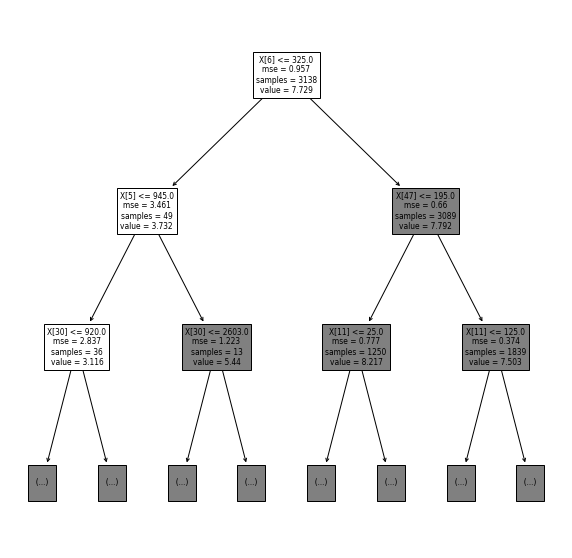

In [ ]:


plt.figure(figsize = [10,10])
tree.plot_tree(dt, max_depth=2)
plt.show()

Decision tree model proves to be more effective than linerar model for this dataset. Predicts audit rates well.

### Random Forest - all tax

In [ ]:
rf = RandomForestRegressor()
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
scores4 = cross_val_score(dt, X,y, cv = 10,  scoring= 'neg_root_mean_squared_error')
scores4, scores4.mean()

# RF regressor doesn't improve over simple decision tree

(array([-0.72503826, -0.58721583, -0.5070276 , -0.52788078, -0.51865097,
        -0.92052774, -0.53240852, -0.5507789 , -0.99192245, -0.45302326]),
 -0.6314474311506348)

### Selected ratios

Next we see how well we can predict just on selected ratios, and see how features are correlated with outcomes

In [ ]:
dftm.dropna(inplace= True)
dftm.shape

(3138, 146)

In [ ]:
X2 = dftm.iloc[: , 131:137]
X2.drop(columns=['wage_income_percentage'], inplace=True)
X2.head()

,volunteer_preparer_percentage,paid_preparer_percentage,dividends_percentage,cap_gain_percentage,eic_percentage
2,0.021285,0.457429,0.114357,0.105175,0.218698
3,0.018252,0.504295,0.167490,0.169315,0.191540
4,0.003128,0.687174,0.099062,0.092805,0.350365
5,0.006281,0.586683,0.055276,0.055276,0.285176
6,0.006812,0.638510,0.084015,0.075386,0.224342


In [ ]:
lm = linear_model.LinearRegression()

In [ ]:
y = dftm['audit_rate']
lm.fit(X2, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
scores2 = cross_val_score(lm, X2, y, cv = 5, scoring= 'neg_root_mean_squared_error')
scores2

array([-0.67255931, -0.32461396, -0.87430199, -0.52307603, -0.75999   ])

In [ ]:
scores2.mean()
# using just selected ratios is predictive, but significantly less than model that uses all characteristics

-0.6309082584632681

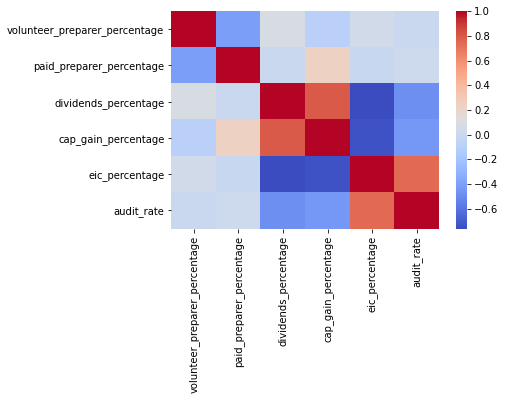

In [ ]:
# Heatmap to show relationships between predictors and audit rates
X22 = X2.copy()
X22['audit_rate'] = y

sns.heatmap(X22.corr(), cmap = 'coolwarm')
plt.show()

# EDA 

## Unemployment Analysis

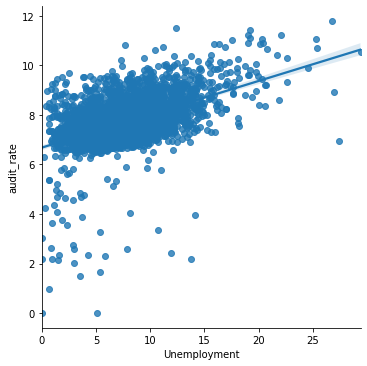

In [ ]:
sns.lmplot(x ='Unemployment', y = 'audit_rate', data = dfmm)

Counties with higher unemployment rates have higher audit rates on average.

## **Racial Analysis**

In [ ]:
dfag = pd.read_csv('https://raw.githubusercontent.com/Roozbeh-jafari/840.Data-Ethics-US-Taxpayers-Algorithms/main/DataSets/audit-demographics-merged.csv?token=ARFHYYEHJGDLYYHUMV6Y46LAWACOE')
# dfag = pd.read_csv('/content/audit-demographics-merged.csv')
dfag.head()

,fips,name,state,Number_of_returns,estimated_exams,audit_rate,audit_rate_trunk,CensusId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Pacific,Citizen,Income,IncomeErr,IncomePerCap,IncomePerCapErr,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Transit,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,Percentage_Male,Percentage_Citizen
0,1001,"Autauga County, Alabama",Alabama,95170.0,721.0,7.575917,7.575917,1001.0,Alabama,Autauga,55221.0,26745.0,28476.0,2.6,75.8,18.5,0.4,1.0,0.0,40725.0,51281.0,2391.0,24974.0,1080.0,12.9,18.6,33.2,17.0,24.2,8.6,17.1,87.5,8.8,0.1,0.5,1.3,1.8,26.5,23986.0,73.6,20.9,5.5,0.0,7.6,0.484327,0.737491
1,1003,"Baldwin County, Alabama",Alabama,362490.0,2833.0,7.815388,7.815388,1003.0,Alabama,Baldwin,195121.0,95314.0,99807.0,4.5,83.1,9.5,0.6,0.7,0.0,147695.0,50254.0,1263.0,27317.0,711.0,13.4,19.2,33.1,17.7,27.1,10.8,11.2,84.7,8.8,0.1,1.0,1.4,3.9,26.4,85953.0,81.5,12.3,5.8,0.4,7.5,0.488487,0.756941
2,1005,"Barbour County, Alabama",Alabama,39440.0,360.0,9.127789,9.127789,1005.0,Alabama,Barbour,26932.0,14497.0,12435.0,4.6,46.2,46.7,0.2,0.4,0.0,20714.0,32964.0,2973.0,16824.0,798.0,26.7,45.3,26.8,16.1,23.1,10.8,23.1,83.8,10.9,0.4,1.8,1.5,1.6,24.1,8597.0,71.8,20.8,7.3,0.1,17.6,0.538282,0.769122
3,1007,"Bibb County, Alabama",Alabama,31840.0,260.0,8.165829,8.165829,1007.0,Alabama,Bibb,22604.0,12073.0,10531.0,2.2,74.5,21.4,0.4,0.1,0.0,17495.0,38678.0,3995.0,18431.0,1618.0,16.8,27.9,21.5,17.9,17.8,19.0,23.7,83.2,13.5,0.5,0.6,1.5,0.7,28.8,8294.0,76.8,16.1,6.7,0.4,8.3,0.534109,0.773978
4,1009,"Blount County, Alabama",Alabama,87970.0,673.0,7.650335,7.650335,1009.0,Alabama,Blount,57710.0,28512.0,29198.0,8.6,87.9,1.5,0.3,0.1,0.0,42345.0,45813.0,3141.0,20532.0,708.0,16.7,27.2,28.5,14.1,23.9,13.5,19.9,84.9,11.2,0.4,0.9,0.4,2.3,34.9,22189.0,82.0,13.5,4.2,0.4,7.7,0.494056,0.733755


In [ ]:
agg_race = dfag[['Hispanic', 'White','Black','Native', 'Asian', 'Pacific']]
agg_race.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3138 entries, 0 to 3137
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Hispanic  3138 non-null   float64
 1   White     3138 non-null   float64
 2   Black     3138 non-null   float64
 3   Native    3138 non-null   float64
 4   Asian     3138 non-null   float64
 5   Pacific   3138 non-null   float64
dtypes: float64(6)
memory usage: 147.2 KB


In [ ]:
round(agg_race.mean(),2)

Hispanic     8.82
White       77.36
Black        8.89
Native       1.71
Asian        1.25
Pacific      0.07
dtype: float64

No handles with labels found to put in legend.


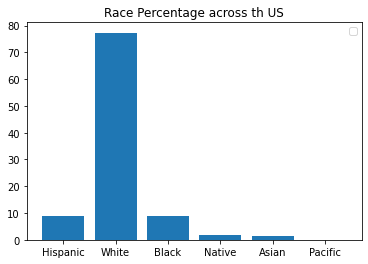

In [ ]:
plt.bar( agg_race.columns, agg_race.mean())
plt.title('Race Percentage across th US')
plt.legend()
plt.show()

In [ ]:
agg_race['balck_white_ratio'] = round(agg_race.Black / agg_race.White * 100, 2)
agg_race['audit_rate'] = dfag.audit_rate
agg_race.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Hispanic,White,Black,Native,Asian,Pacific,balck_white_ratio,audit_rate
0,2.6,75.8,18.5,0.4,1.0,0.0,24.41,7.575917
1,4.5,83.1,9.5,0.6,0.7,0.0,11.43,7.815388
2,4.6,46.2,46.7,0.2,0.4,0.0,101.08,9.127789
3,2.2,74.5,21.4,0.4,0.1,0.0,28.72,8.165829
4,8.6,87.9,1.5,0.3,0.1,0.0,1.71,7.650335


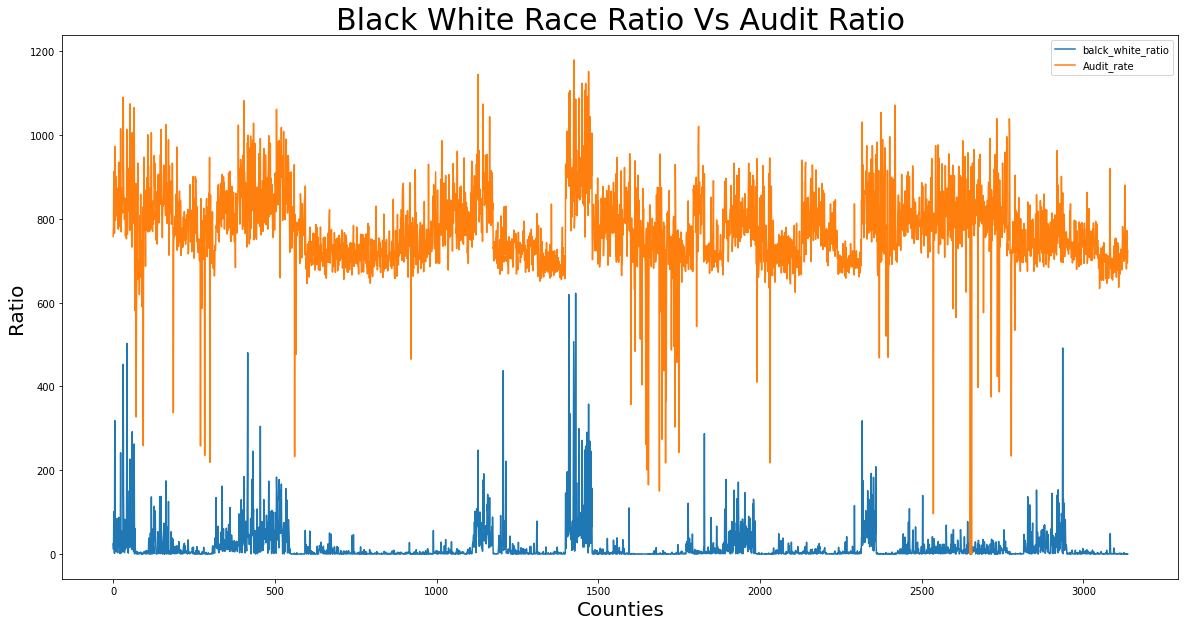

In [ ]:
plt.figure(figsize=(20,10))

plt.plot(agg_race.balck_white_ratio, label='balck_white_ratio')
plt.plot(agg_race.audit_rate * 100, label='Audit_rate')

plt.xlabel('Counties', fontdict={'fontsize': 20})
plt.ylabel('Ratio', fontdict={'fontsize': 20})

plt.title('Black White Race Ratio Vs Audit Ratio', fontdict={'fontsize': 30})
plt.legend()

plt.show()

The graph shows a correlation between the black-white ratio and audit rate. The higher the black-white percentage, the higher the audit rate is.

## Gender Analysis

In [ ]:
dfag['MalePct'] = dfag['Men'] / dfag['TotalPop']

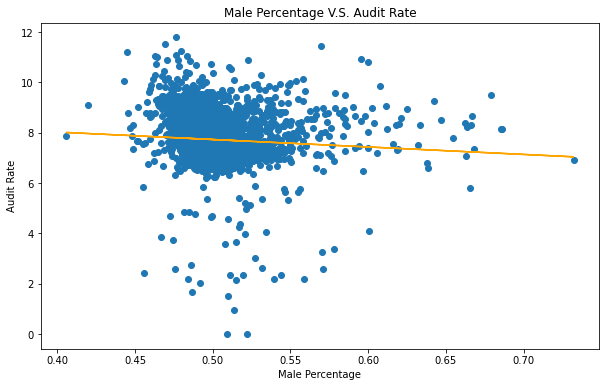

In [ ]:
x = dfag['MalePct']
y = dfag['audit_rate']

plt.figure(figsize=(10,6))
plt.xlabel('Male Percentage')
plt.ylabel('Audit Rate')
plt.title('Male Percentage V.S. Audit Rate')
plt.scatter(x, y)

a, b = np.polyfit(x, y, 1)
# a=slope, b=intercept
plt.plot(x, a*x + b, color='orange')

plt.show()

The scatter plot presents the relationship between audit rate and male percentage. In most of the counties, the male portion mostly range between 45 and 55 percent. The regression line indicate a weak linear relationship between these two variables. Gender doesn't significantly influence the audit rate. 

Top 30

In [ ]:
df_top30 = dfag.sort_values('audit_rate', ascending=False)[['audit_rate', 'MalePct']].head(30)
df_top30.head()

,audit_rate,MalePct
1425,11.790079,0.476180
1470,11.512648,0.469218
1128,11.444653,0.569524
1450,11.233596,0.479763
1461,11.228534,0.445161


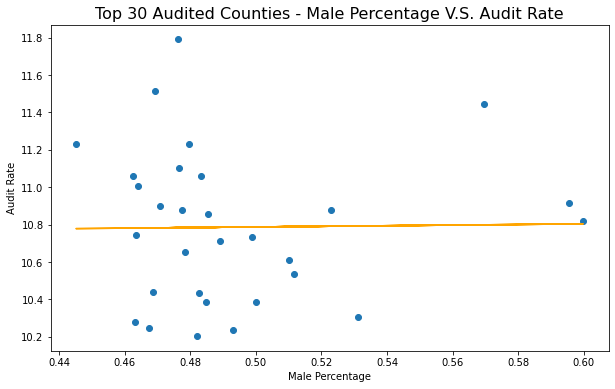

In [ ]:
x = df_top30['MalePct']
y = df_top30['audit_rate']

plt.figure(figsize=(10,6))
plt.xlabel('Male Percentage')
plt.ylabel('Audit Rate')
plt.title('Top 30 Audited Counties - Male Percentage V.S. Audit Rate', fontsize=16)
plt.scatter(x, y)

a, b = np.polyfit(x, y, 1)
# a=slope, b=intercept
plt.plot(x, a*x + b, color='orange')

plt.show()

Bottom 30

In [ ]:
df_bottom30 = dfag.sort_values('audit_rate', ascending=True)[['audit_rate', 'MalePct']].head(30)
df_bottom30.head()

,audit_rate,MalePct
2650,0.000000,0.522124
2654,0.000000,0.509363
2536,0.961538,0.513475
1689,1.503759,0.509753
1655,1.652893,0.486585


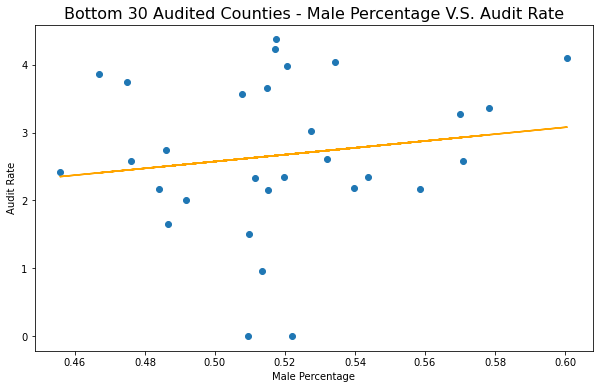

In [ ]:
x = df_bottom30['MalePct']
y = df_bottom30['audit_rate']

plt.figure(figsize=(10,6))
plt.xlabel('Male Percentage')
plt.ylabel('Audit Rate')
plt.title('Bottom 30 Audited Counties - Male Percentage V.S. Audit Rate', fontsize=16)
plt.scatter(x, y)

a, b = np.polyfit(x, y, 1)
# a=slope, b=intercept
plt.plot(x, a*x + b, color='orange')
plt.show()

If we look into the counties with the highest and lowest audit rates, respectively, gender doesn't demonstrate a strong correlation with audit rate as well.

## Professional Rate Analysis
Professional: percent employed in management, business, science, and arts


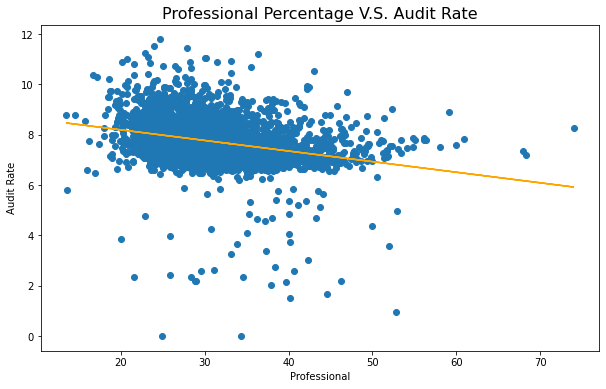

In [ ]:
x = dfag['Professional']
y = dfag['audit_rate']

plt.figure(figsize=(10,6))
plt.xlabel('Professional')
plt.ylabel('Audit Rate')
plt.title('Professional Percentage V.S. Audit Rate', fontsize=16)
plt.scatter(x, y)

a, b = np.polyfit(x, y, 1)
# a=slope, b=intercept
plt.plot(x, a*x + b, color='orange')
plt.show()

The plot shows that professional percentage have a correlation with audit rate. According to the definition, the professional percentage indicates the percentage employed in the fields of specialty that requires advanced education or training.

Counties with higher professional percentages, on average, have lower audit rates. We may infer that the higher the professional or educated level is, the counties are less likely to be audited.

Top 30

In [ ]:
df_top30 = dfag.sort_values('audit_rate', ascending=False)[['audit_rate', 'Professional']].head(30)
df_top30.head()

,audit_rate,Professional
1425,11.790079,24.7
1470,11.512648,23.9
1128,11.444653,27.9
1450,11.233596,22.9
1461,11.228534,36.4


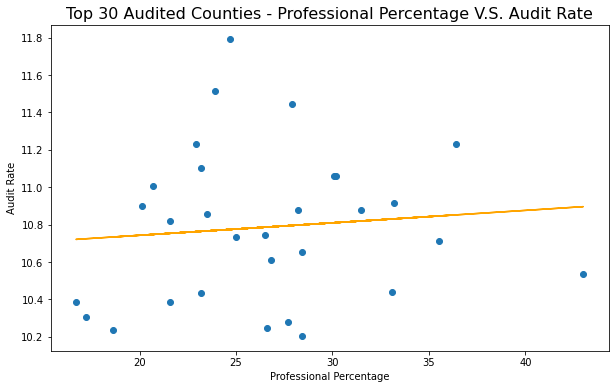

In [ ]:
x = df_top30['Professional']
y = df_top30['audit_rate']

plt.figure(figsize=(10,6))
plt.xlabel('Professional Percentage')
plt.ylabel('Audit Rate')
plt.title('Top 30 Audited Counties - Professional Percentage V.S. Audit Rate', fontsize=16)
plt.scatter(x, y)

a, b = np.polyfit(x, y, 1)
# a=slope, b=intercept
plt.plot(x, a*x + b, color='orange')
plt.show()

Bottom 30

In [ ]:
df_bottom30 = dfag.sort_values('audit_rate', ascending=True)[['audit_rate', 'Professional']].head(30)
df_bottom30.head()

,audit_rate,Professional
2650,0.000000,24.9
2654,0.000000,34.3
2536,0.961538,52.8
1689,1.503759,40.2
1655,1.652893,44.6


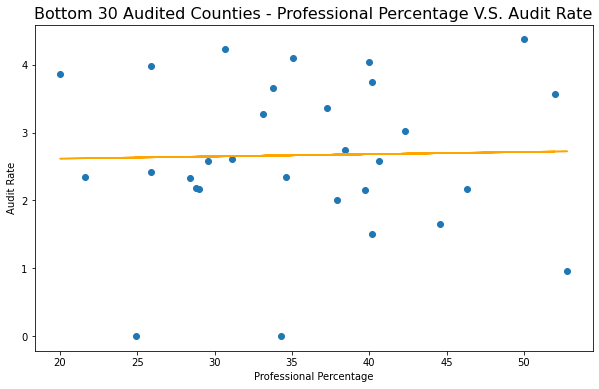

In [ ]:
x = df_bottom30['Professional']
y = df_bottom30['audit_rate']

plt.figure(figsize=(10,6))
plt.xlabel('Professional Percentage')
plt.ylabel('Audit Rate')
plt.title('Bottom 30 Audited Counties - Professional Percentage V.S. Audit Rate', fontsize=16)
plt.scatter(x, y)

a, b = np.polyfit(x, y, 1)
# a=slope, b=intercept
plt.plot(x, a*x + b, color='orange')
plt.show()

## Income Analysis
[Link to tablaeu public](https://public.tableau.com/app/profile/shuyi.zhu/viz/840AuditRate-Income/D_AR)

In [ ]:
%%HTML
<div class='tableauPlaceholder' id='viz1622126085748' style='position: relative'><noscript><a href='#'><img alt='D_AR ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;84&#47;840AuditRate-Income&#47;D_AR&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='840AuditRate-Income&#47;D_AR' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;84&#47;840AuditRate-Income&#47;D_AR&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='zh-TW' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1622126085748');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.minWidth='420px';vizElement.style.maxWidth='650px';vizElement.style.width='100%';vizElement.style.minHeight='587px';vizElement.style.maxHeight='887px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.minWidth='420px';vizElement.style.maxWidth='650px';vizElement.style.width='100%';vizElement.style.minHeight='587px';vizElement.style.maxHeight='887px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else { vizElement.style.width='100%';vizElement.style.height='927px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

* Average income level below $50,000 shows the highest audit rate. 
* Lower income level shows a higher audit rate.
* Individuals with higher poverty level is likely to have a higher audit rate.


[Link to tablaeu public](https://public.tableau.com/app/profile/shuyi.zhu/viz/840AuditRate-Income/D_AuditonCountyLevel)

In [ ]:
%%HTML
<div class='tableauPlaceholder' id='viz1622126652455' style='position: relative'><noscript><a href='#'><img alt='D_Audit on County Level ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;84&#47;840AuditRate-Income&#47;D_AuditonCountyLevel&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='840AuditRate-Income&#47;D_AuditonCountyLevel' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;84&#47;840AuditRate-Income&#47;D_AuditonCountyLevel&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='zh-TW' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1622126652455');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.minWidth='420px';vizElement.style.maxWidth='650px';vizElement.style.width='100%';vizElement.style.minHeight='587px';vizElement.style.maxHeight='887px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.minWidth='420px';vizElement.style.maxWidth='650px';vizElement.style.width='100%';vizElement.style.minHeight='587px';vizElement.style.maxHeight='887px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else { vizElement.style.width='100%';vizElement.style.height='927px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

* States in southern part show a lower average household income, yet, the average audit rate is higher. 
* Median household income in the United States was $56,516 in 2015.
* Majority of the counties are below the median household income  but receive the highest audit rate. 



## Map - IRS Audit Rates by County
[Link to tablaeu public](https://public.tableau.com/app/profile/scott1352/viz/IRSAuditRatesbyCounty/Dashboard2)

In [ ]:
%%HTML
<div class='tableauPlaceholder' id='viz1622126219533' style='position: relative'><noscript><a href='#'><img alt='Mean Values:Audit rate:           7.73Black pop %:       8.89Native pop %:     1.71White pop %:   77.34 Income:            46,833Dividends %:    14.96Cap Gains %:    15.01 ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;IR&#47;IRSAuditRatesbyCounty&#47;Dashboard2&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='IRSAuditRatesbyCounty&#47;Dashboard2' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;IR&#47;IRSAuditRatesbyCounty&#47;Dashboard2&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='zh-TW' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1622126219533');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.minWidth='1020px';vizElement.style.maxWidth='1250px';vizElement.style.width='100%';vizElement.style.minHeight='487px';vizElement.style.maxHeight='787px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.minWidth='1020px';vizElement.style.maxWidth='1250px';vizElement.style.width='100%';vizElement.style.minHeight='487px';vizElement.style.maxHeight='787px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else { vizElement.style.width='100%';vizElement.style.height='727px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

According to the map, income tax filings in some counties were audited at a higher rate than the nation as a whole.



# Conclusions

**Consequentialism:**

The algorithm doesn't result in a good outcome on balance. Lower-income taxpayers face a higher chance of an audit. If the audit algorithm is unfair, it will result in certain groups of people will be treated unfairly in terms of time input in filing tax return documents.



**Deontology:**

From the perspective of deontology, the algorithm seems not consistent with moral rules. People have the rights to be treated equally; a unfair audit algorithm will against that right, especially when a high audit rate could be an indicator of less trust towards the specific minority.



# Recommendations
**For individuals**
* Programs to help low income taxpayers - VITA (Volunteer Income Tax Assistance)

**For improving algorithmic fairness**
* Change what algorithm optimizes 
* Probability of change vs amount of expected change 

**Tax Policy Changes**
* Increase IRS enforcement budget
* Make it easier to file taxes
